In [ ]:
# Jovian Commit Essentials
# Please retain and execute this cell without modifying the contents for `jovian.commit` to work
!pip install jovian --upgrade -q
import jovian
jovian.utils.colab.set_colab_file_id('1gSEZeMSh28UNSDZFcdZMM1bnAlkctArS')

In [ ]:
pip install keras-tuner

## Contents

1. [Import Libraries](#import-libraries)

# Import Libraries <a name ="import-libraries"></a>




In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import numpy as np
import zipfile
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, Dropout, Flatten, Dense, MaxPooling2D
from tensorflow.keras.optimizers import Adam
import kerastuner
from kerastuner import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters

# Getting dataset from kaggle 
[Intel-Image-Classification](https://www.kaggle.com/puneet6060/intel-image-classification)

In [ ]:
from google.colab import files
files.upload()

In [6]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

In [8]:
!kaggle datasets download -d puneet6060/intel-image-classification

intel-image-classification.zip: Skipping, found more recently modified local copy (use --force to force download)


## Extracting data

In [13]:
zip_ref = zipfile.ZipFile('/content/intel-image-classification.zip', 'r')
zip_ref.extractall('/tmp')
zip_ref.close()


## Assigning appropriate directories

In [10]:
train_dir  = ('/tmp/seg_train/seg_train')
validation_dir = ('/tmp/seg_test/seg_test')
preds_dir = ('/tmp/seg_pred/seg_pred')

In [14]:
train_buildings_dir = os.path.join('/tmp/seg_train/seg_train', 'buildings')
train_glacier_dir = os.path.join('/tmp/seg_train/seg_train', 'glacier')

In [15]:
train_buildings_list = os.listdir(train_buildings_dir)
train_glacier_list = os.listdir(train_glacier_dir)


### Visualising training-dataset 
Images are only show for building & glacier

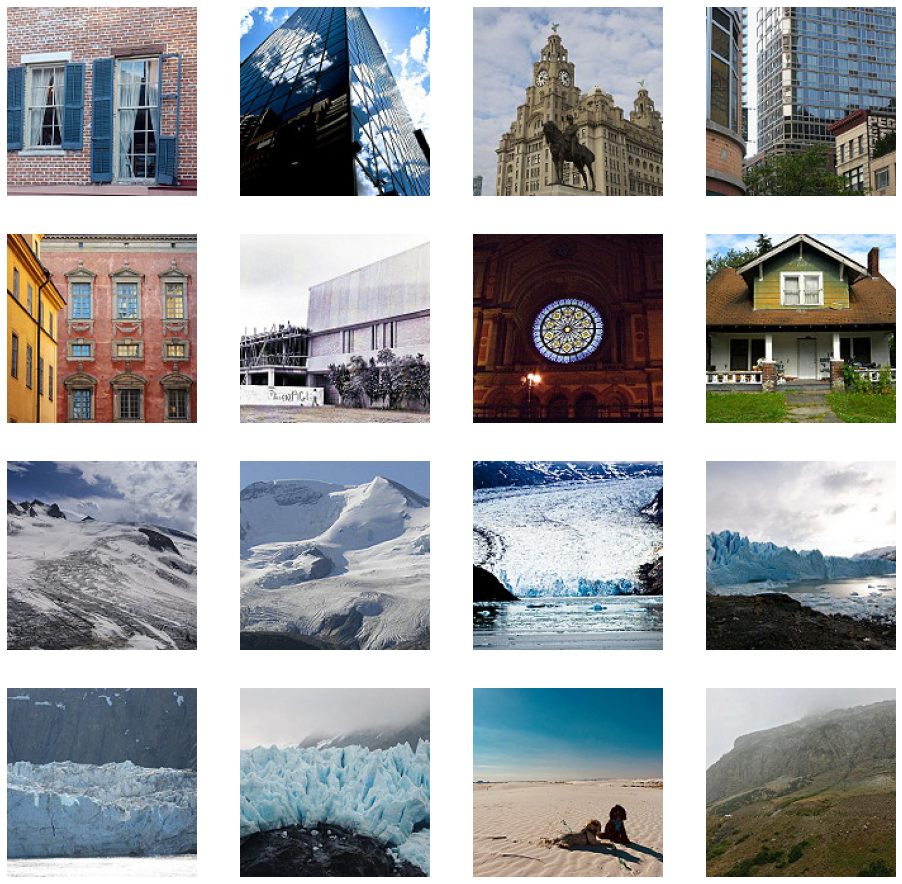

In [16]:
index = 10
next_building_img = [os.path.join(train_buildings_dir, fname) for fname in train_buildings_list][index-8:index]
next_building_glacier = [os.path.join(train_glacier_dir, fname) for fname in train_glacier_list][index-8:index]


fig = plt.gcf()
fig.set_size_inches(16,16)

for i, img_path in enumerate(next_building_img + next_building_glacier):
  
  subplot = plt.subplot(4,4, i+1)
  subplot.axis('off')
  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

## Initialising ImageDataGenerator for data augmentation
Only apply rescaling of image in inital experiment

In [17]:
train_datagen = ImageDataGenerator(rescale = 1.0/255)
                                  #  rotation_range = 40,
                                  #  height_shift_range = 0.2,
                                  #  width_shift_range = 0.2, 
                                  #  fill_mode = 'nearest', 
																	#  shear_range = 25,
                                  #  horizontal_flip= True)

validation_datagen = ImageDataGenerator(rescale = 1.0/255)
                                  #  rotation_range = 40,
                                  #  height_shift_range = 0.2,
                                  #  width_shift_range = 0.2, 
                                  #  fill_mode = 'nearest', 
																	#  shear_range = 25,
                                  #  horizontal_flip= True)

## Initialising data loaders 
Feed batch sizes of 64 images to model 


In [ ]:
train_generator = train_datagen.flow_from_directory(train_dir, target_size=(150,150), batch_size = 64, class_mode='categorical')
validation_generator = validation_datagen.flow_from_directory(validation_dir, target_size=(150,150), batch_size = 64, class_mode='categorical')

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


### Hyperparameter Tuning
Defining build_model function to be passed into keras-tuner library 

In [ ]:
def build_model(hp):
  first_layer_units = hp.Int("Input_conv_layer_units", 32, 512, 16)
  first_layer_dropout = hp.Float("Input_dropout_prob", 0, 0.5, 0.1)
  first_dense_units = hp.Int("first_dense_units", 32, 512, 32)

  model = Sequential()
  model.add(Conv2D(first_layer_units, (3,3), activation = 'relu', input_shape =(150,150,3)))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(2,2))
  model.add(Dropout(first_layer_dropout))

  for i in range(hp.Int("n_intermediate_layers", 1,4)):
    model.add(Conv2D(hp.Int(f"conv{i+1}_layer_units", 32, 256, 16), (3,3), activation = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2,2))
    model.add(Dropout(hp.Float("dropout_prob", 0, 0.5, 0.1)))
  
  model.add(Flatten())
  model.add(Dense(first_dense_units, activation = 'relu'))
  model.add(Dense(6, activation = 'softmax'))

  model.compile(loss = 'categorical_crossentropy',optimizer = 'adam', metrics = ['accuracy'])

  return model
  


In [ ]:
tuner = RandomSearch(build_model, objective = 'val_accuracy', max_trials = 10, directory = 'project', project_name = 'intel_image_classification')


INFO:tensorflow:Reloading Oracle from existing project project/intel_image_classification/oracle.json


In [ ]:
tuner.search(train_generator, batch_size = 32, epochs = 1, validation_data = validation_generator)

Trial 10 Complete [00h 01m 54s]
val_accuracy: 0.28833332657814026

Best val_accuracy So Far: 0.4143333435058594
Total elapsed time: 00h 19m 36s
INFO:tensorflow:Oracle triggered exit


In [ ]:
model = tuner.get_best_models(num_models=1)[0]

### Optimal Hyperparameters found

In [ ]:
tuner.get_best_hyperparameters()[0].values

{'Input_conv_layer_units': 112,
 'Input_dropout_prob': 0.30000000000000004,
 'conv1_layer_units': 112,
 'conv2_layer_units': 112,
 'conv3_layer_units': 176,
 'dropout_prob': 0.2,
 'first_dense_units': 352,
 'n_intermediate_layers': 2}

### Train Model for more epochs
added several callbacks

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
early_stop = EarlyStopping(monitor= 'val_accuracy', patience =5)

checkpoint_dir = './training_checkpoints/cp.ckpt'
checkpoint_callback = ModelCheckpoint(checkpoint_dir,save_weights_only=True, verbose = 1)
# checkpoint_dir = os.path.dirname(checkpoint_dir)  # get dir name 
# print(checkpoint_dir)

In [ ]:
history = model.fit(train_generator, batch_size = 64, epochs = 15, callbacks = [checkpoint_callback], validation_data = validation_generator)

Epoch 1/15
55/55 [==============================] - 104s 2s/step - loss: 0.3840 - accuracy: 0.8613 - val_loss: 0.5222 - val_accuracy: 0.8247

Epoch 00001: saving model to ./training_checkpoints/cp.ckpt
Epoch 2/15
55/55 [==============================] - 102s 2s/step - loss: 0.3863 - accuracy: 0.8616 - val_loss: 0.4499 - val_accuracy: 0.8427

Epoch 00002: saving model to ./training_checkpoints/cp.ckpt
Epoch 3/15
55/55 [==============================] - 100s 2s/step - loss: 0.3761 - accuracy: 0.8650 - val_loss: 0.4854 - val_accuracy: 0.8393

Epoch 00003: saving model to ./training_checkpoints/cp.ckpt
Epoch 4/15
55/55 [==============================] - 100s 2s/step - loss: 0.3741 - accuracy: 0.8674 - val_loss: 0.5654 - val_accuracy: 0.8210

Epoch 00004: saving model to ./training_checkpoints/cp.ckpt
Epoch 5/15
55/55 [==============================] - 100s 2s/step - loss: 0.3685 - accuracy: 0.8685 - val_loss: 0.4664 - val_accuracy: 0.8457

Epoch 00005: saving model to ./training_checkpoint

### Conclusion
Model validation accuracy hovers around 80%. There is room for improvement.

In [ ]:
model.save('model_intel_image_classification.h5')

### Future Updates: 
1. Identify images that model predicts incorrectly and identify model's weaknesses
2. Using Transfer Learning on dataset